In [1]:
import os
import re
import uproot
import numpy as np

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
fname = os.path.expandvars("$HOME/Software/WCSimFQTuningTools/Time/fiTQun/tres_trueq_2Dhistogram.root")
# fname  = os.path.expandvars("$LUSTRE/Time/e-/tuning/tres_trueq_2Dhistogram.root")

f = uproot.open(fname)

print(f.classnames())

{'htimepdf_direct_194.715225;1': 'TH2D', 'htimepdf_indirect_194.715225;1': 'TH2D', 'htimepdf_direct_218.853424;1': 'TH2D', 'htimepdf_indirect_218.853424;1': 'TH2D', 'htimepdf_direct_242.238785;1': 'TH2D', 'htimepdf_indirect_242.238785;1': 'TH2D', 'htimepdf_direct_265.070618;1': 'TH2D', 'htimepdf_indirect_265.070618;1': 'TH2D', 'htimepdf_direct_287.480835;1': 'TH2D', 'htimepdf_indirect_287.480835;1': 'TH2D', 'htimepdf_direct_309.561035;1': 'TH2D', 'htimepdf_indirect_309.561035;1': 'TH2D', 'htimepdf_direct_331.377197;1': 'TH2D', 'htimepdf_indirect_331.377197;1': 'TH2D', 'htimepdf_direct_352.978241;1': 'TH2D', 'htimepdf_indirect_352.978241;1': 'TH2D', 'htimepdf_direct_374.401459;1': 'TH2D', 'htimepdf_indirect_374.401459;1': 'TH2D', 'htimepdf_direct_395.675690;1': 'TH2D', 'htimepdf_indirect_395.675690;1': 'TH2D', 'htimepdf_direct_416.823761;1': 'TH2D', 'htimepdf_indirect_416.823761;1': 'TH2D', 'htimepdf_direct_437.863983;1': 'TH2D', 'htimepdf_indirect_437.863983;1': 'TH2D', 'htimepdf_direc

In [4]:
# get simulated momenta
histonames = list(f.classnames().keys())
momenta = []
for name in histonames:
    m = re.match(r"htimepdf_direct_(\d+\.\d+)", name)
    if m: momenta.append(float(m.group(1)))
momenta = np.array(momenta)
momenta.sort()

Selecting p = 500.473053 (MeV/c)


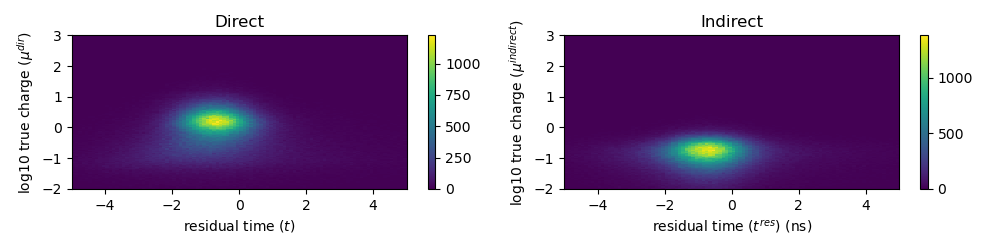

In [5]:
# read 2D histogram
p = np.random.choice(momenta)
print(f"Selecting p = {p} (MeV/c)")

try:
    Hdirect  , tresbins, trueqbins = f[f"htimepdf_direct_{p}"]  .to_numpy()
    Hindirect, tresbins, trueqbins = f[f"htimepdf_indirect_{p}"].to_numpy()
except uproot.KeyInFileError:
    Hdirect  , tresbins, trueqbins = f[f"htimepdf_direct_{p}0"].to_numpy()
    Hindirect, tresbins, trueqbins = f[f"htimepdf_indirect_{p}0"].to_numpy()

plt.figure(figsize=[10, 2.5])

plt.subplot(121)
plt.title("Direct")
plt.pcolormesh(tresbins, trueqbins, Hdirect.T)
plt.xlabel(r"residual time ($t$)")
plt.ylabel(r"log10 true charge ($\mu^{dir}$)")
plt.colorbar()

plt.subplot(122)
plt.title("Indirect")
plt.pcolormesh(tresbins, trueqbins, Hindirect.T)
plt.xlabel(r"residual time ($t^{res}$) (ns)")
plt.ylabel(r"log10 true charge ($\mu^{indirect}$)")
plt.colorbar()

plt.tight_layout()

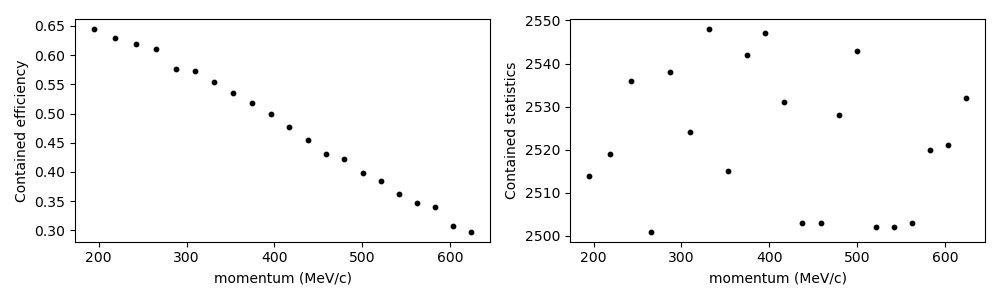

In [6]:
ps, ntotal    = f["Total"]    .values()
ps, contained = f["Contained"].values()

efficiency = contained/ntotal

plt.figure(figsize=[10, 3])

plt.subplot(121)
plt.scatter(ps, efficiency, s=10, color="k")
plt.xlabel("momentum (MeV/c)")
plt.ylabel("Contained efficiency")

plt.subplot(122)
plt.scatter(ps, contained, s=10, color="k")
plt.xlabel("momentum (MeV/c)")
plt.ylabel("Contained statistics")

plt.tight_layout()

### Indirect Time PDF

In [7]:
from scipy.optimize import curve_fit

# function to fit
def indirect_timepdf(t, delta, sig, gamma):
    out = np.zeros(len(t))

    dt = t - delta
    A = 1./(np.sqrt(np.pi/2.)*sig + 2*gamma)

    sel = dt<0
    out[sel]  = A*np.exp(-dt[sel]**2/(2.*sig**2))
    out[~sel] = A*(dt[~sel]/gamma + 1.)*np.exp(-dt[~sel]/gamma)
    
    return out

In [8]:
# get data (tres distribution for each momentum)
timepdf = dict()
for p in momenta:
    try:
        Hindirect, tresbins, trueqbins = f[f"htimepdf_indirect_{p}"].to_numpy()
    except uproot.KeyInFileError:
        Hindirect, tresbins, trueqbins = f[f"htimepdf_indirect_{p}0"].to_numpy()

    h    = Hindirect.sum(axis=1)
    norm = np.sum(h*(tresbins[1:]-tresbins[:-1]))
    timepdf[p] = h/norm

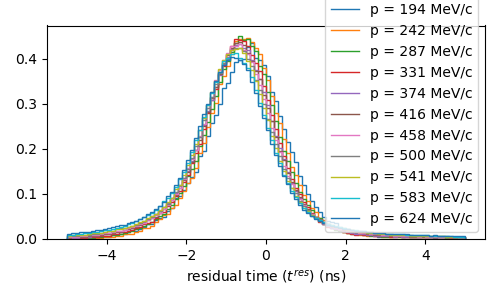

In [9]:
p = momenta[0]

plt.figure(figsize=[5, 3])

for p in momenta[::2]:
    h = timepdf[p]
    plt.stairs(h, tresbins, label=f"p = {int(p)} MeV/c")

plt.xlabel(r"residual time ($t^{res}$) (ns)")
plt.legend()
plt.tight_layout()

In [10]:
# merge momentum distributions
pdf = np.zeros(len(tresbins)-1)
for p in momenta: pdf += timepdf[p]
norm = np.sum(pdf*(tresbins[1:]-tresbins[:-1]))
pdf = pdf/norm

tress = (tresbins[1:] + tresbins[:-1])/2.
params, covariance = curve_fit(indirect_timepdf, tress, pdf, bounds=([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))
params, covariance = curve_fit(indirect_timepdf, tress, pdf)

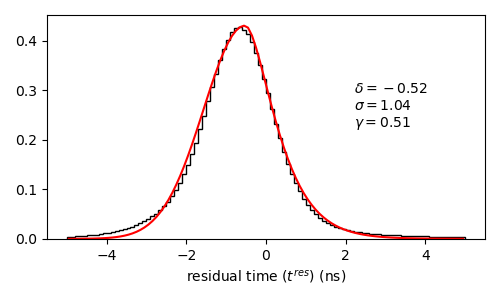

In [11]:
fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(111)

ax.stairs(pdf, tresbins, color="k", label=f"p = {int(p)} MeV/c")

ts   = np.linspace(tress[0], tress[-1], 100)
pdf_ = indirect_timepdf(ts, *params)
ax.plot(ts, pdf_, color="r")

text = fr"$\delta = {round(params[0], 2)}$" + "\n" \
     + fr"$\sigma = {round(params[1], 2)}$" + "\n" \
     + fr"$\gamma = {round(params[2], 2)}$"


ax.text(0.7, 0.5, text, transform=ax.transAxes)

ax.set_xlabel(r"residual time ($t^{res}$) (ns)")
fig.tight_layout()

### Conversion factor charge-nphotons-momentum

Conversion factor (photons/charge) 50.96369508674931


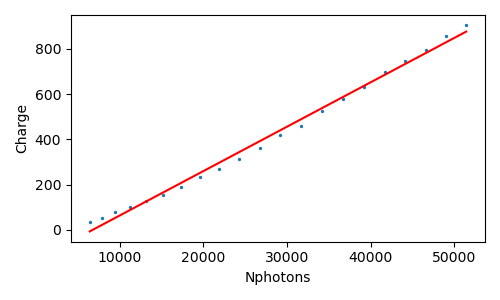

In [12]:
nphotons, charge = f["Conversion"].values()

pars = np.polyfit(nphotons, charge, 1)
print("Conversion factor (photons/charge)", (1/pars[0]))

fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(111)

plt.scatter(nphotons, charge, s=2)

pol = np.poly1d(pars)
plt.plot(nphotons, pol(nphotons), color="red")

plt.xlabel("Nphotons")
plt.ylabel("Charge")

plt.tight_layout()